In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dask
import dask.dataframe as ddf
import numpy as np
from tqdm import tqdm
import pickle
import gc
#import xgboost

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
hgg = pd.read_parquet('/scratch365/cmoore24/training/data/hgg.parquet')
hbb = pd.read_parquet('/scratch365/cmoore24/training/data/hbb.parquet')

In [4]:
background = pd.read_parquet('/scratch365/cmoore24/training/data/qcd.parquet')

In [5]:
var_keys = list(hgg.keys())

In [6]:
items = [#'FatJets.area',
  'FatJets.eta',
  'FatJets.mass',
  'FatJets.msoftdrop',
  'FatJets.n2b1',
  'FatJets.n3b1',
#  'FatJets.phi',
  'FatJets.pt',
  'FatJets.nConstituents',
  'FatJets.color_ring',
  'FatJets.d2b1',
  'FatJets.u1',
  'FatJets.u2',
  'FatJets.u3',
#  'FatJets.d3',
  'FatJets.m2',
  'FatJets.m3',
  'FatJets.n4',
 'isSignal',
]

In [7]:
hgg['isSignal'] = np.ones_like(hgg[items[0]])

In [8]:
background['isSignal'] = np.zeros_like(background[items[0]])

In [9]:
# sizes = []
# for i in background:
#     sizes.append(len(background[i]))

# losses = [(x - min(sizes)) for x in sizes]
# for i in background:
#     background[i] = background[i][:min(sizes)]

In [10]:
small_sig = hgg[items]
small_bkg = background[items]
#del(background)
#gc.collect()

In [11]:
NDIM = len(items) - 1
df_all = pd.concat([small_sig, small_bkg])
dataset = df_all.values
X = dataset[:, 0:NDIM]
y = dataset[:, NDIM]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
X_train

array([[ 0.00904232,  0.68638687, -0.94993598, ...,  0.21838946,
         0.64381024, -0.08302013],
       [-0.28850936, -1.18768269, -1.1211731 , ..., -0.11069789,
         0.47051532,  0.62234952],
       [ 0.03314437,  0.90291284,  1.0602389 , ...,  0.55139502,
         0.43355423, -0.65699284],
       ...,
       [-1.61623912,  0.43252884,  1.67073646, ..., -0.04538613,
         0.88512465, -0.68634612],
       [ 0.66724943,  0.29813342,  0.93367233, ..., -0.7165947 ,
         0.26550214, -0.63733746],
       [ 0.39515954, -0.0677208 , -1.36313859, ...,  0.60850634,
         0.36394736,  2.76022649]])

In [14]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [15]:
# Build our model.
# gc.collect()
# torch.cuda.empty_cache()

class NeuralNetwork(nn.Module):
    def __init__(self, width=64):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(items)-1, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()

model= nn.DataParallel(model,device_ids = [0, 
                                           1, 
                                           2, 
                                           3
                                          ])
model.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
len(X_train)

1096149

In [17]:
portion = 2**14
if portion > (len(X_train)*0.5):
    raise Exception('Batch size too big')
print(portion)

16384


In [18]:
losses, test_losses = [], []
min_loss, stale_epochs = 100.0, 0
stale_list = ['N/A']

batch_size = portion
for t in tqdm(range(20)):
    batch_loss, batch_test_loss = [], []
    
    for b in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[b : b + batch_size]
        y_batch = y_train[b : b + batch_size]
        model.train()
        y_pred = model(X_batch)
        #print(f"pred: {y_pred}")
        y_b = y_batch.view(-1,1)
        #print(f"y_b: {y_b}")

        # Compute and print loss.
        loss = loss_fn(y_pred, y_b)
        #print(f"loss: {loss.item()}")
        batch_loss.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        with torch.inference_mode():

            model.eval()
            test_pred = model(X_test)

            test_label = y_test.view_as(test_pred)
            test_loss = loss_fn(test_pred, test_label)
            batch_test_loss.append(test_loss.item())

             
            # Monitor the loss function to prevent overtraining.
#             if stale_epochs > 20:
#                 stale_list.append(t)
#                 break

#             if test_loss.item() - min_loss < 0:
#                 min_loss = test_loss.item()
#                 stale_epochs = 0
#                 torch.save(model.state_dict(), "pytorch_model_best.pth")
#             else:
#                 stale_epochs += 1
#                 if stale_epochs % 5 == 0:
#                     print(stale_epochs)
    
    losses.append(np.mean(batch_loss))
    test_losses.append(np.mean(batch_test_loss))
#print(f'Stale at epoch {stale_list[1]}')

100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


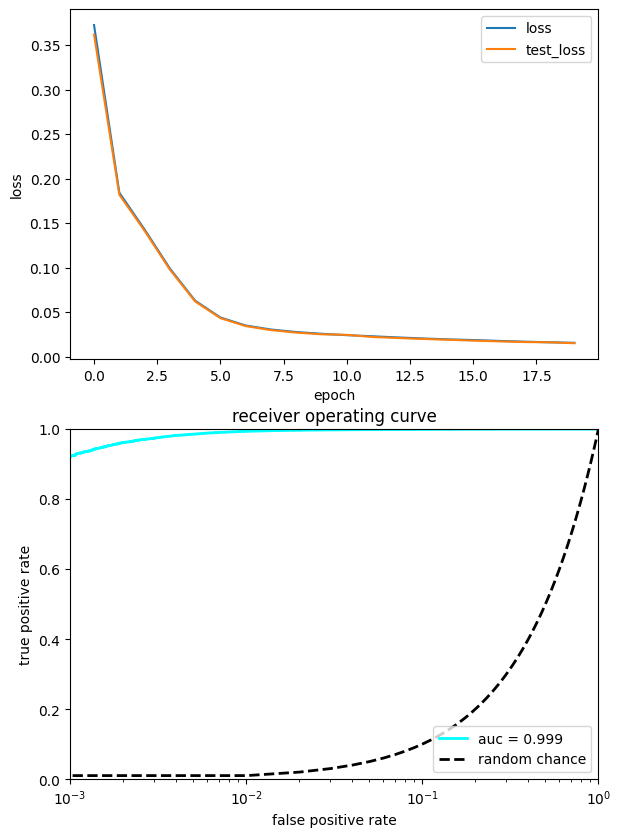

In [19]:
with torch.inference_mode():
    # plot loss vs epoch
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(losses, label="loss")
    ax.plot(test_losses, label="test_loss")
    ax.legend(loc="upper right")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

    # Plot ROC
    X_test_in = X_test
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test.cpu(), Y_predict.cpu())
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.set_xscale("log")
    ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([1e-3, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.set_title("receiver operating curve")
    ax.legend(loc="lower right")
    plt.show()

In [20]:
items2 = items[:-1]

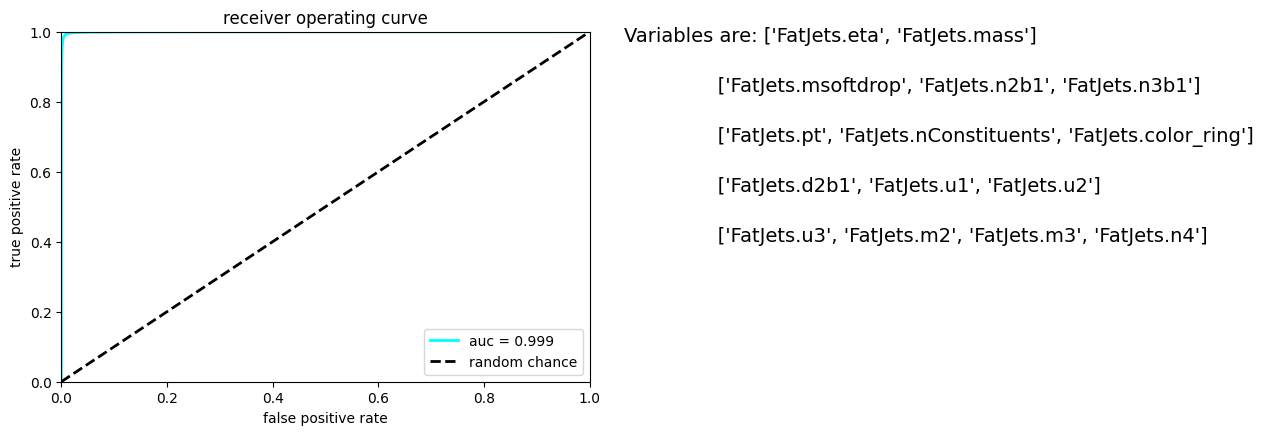

In [21]:
with torch.inference_mode():
    # plot loss vs epoch
    plt.figure(figsize=(15, 10))
#     ax = plt.subplot(2, 2, 1)
#     ax.plot(losses, label="loss")
#     ax.plot(test_losses, label="test_loss")
#     ax.legend(loc="upper right")
#     ax.set_xlabel("epoch")
#     ax.set_ylabel("loss")

    # Plot ROC
    X_test_in = X_test
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test.cpu(), Y_predict.cpu())
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.set_title("receiver operating curve")
    ax.legend(loc="lower right")
    textstr1 = (f'Variables are: {str(items2[:len(items2)//6])}')
    textstr2 = (f'               {str(items2[len(items2)//6:len(items2)//6 + 3])}')
    textstr3 = (f'               {str(items2[len(items2)//6 + 3:len(items2)//6 + 6])}')
    textstr4 = (f'               {str(items2[len(items2)//6 + 6:len(items2)//6 + 9])}')
    textstr5 = (f'               {str(items2[len(items2)//6 + 9:len(items2)//6 + 13])}')
#     textstr6 = (f'               {str(items2[len(items2)//6 + 12:len(items2)//6 + 15])}')
    plt.gcf().text(0.5, 0.45, textstr1, fontsize=14)
    plt.gcf().text(0.5, 0.4, textstr2, fontsize=14)
    plt.gcf().text(0.5, 0.35, textstr3, fontsize=14)
    plt.gcf().text(0.5, 0.3, textstr4, fontsize=14)
    plt.gcf().text(0.5, 0.25, textstr5, fontsize=14)
#    plt.gcf().text(0.5, 0.2, textstr6, fontsize=14)
    plt.show()